In [134]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [135]:
data_dir = 'data/uab_data/keras/'
data_dir = pathlib.Path(data_dir)

image_count = len(list(data_dir.glob('*/*.tif')))
print(image_count)

97


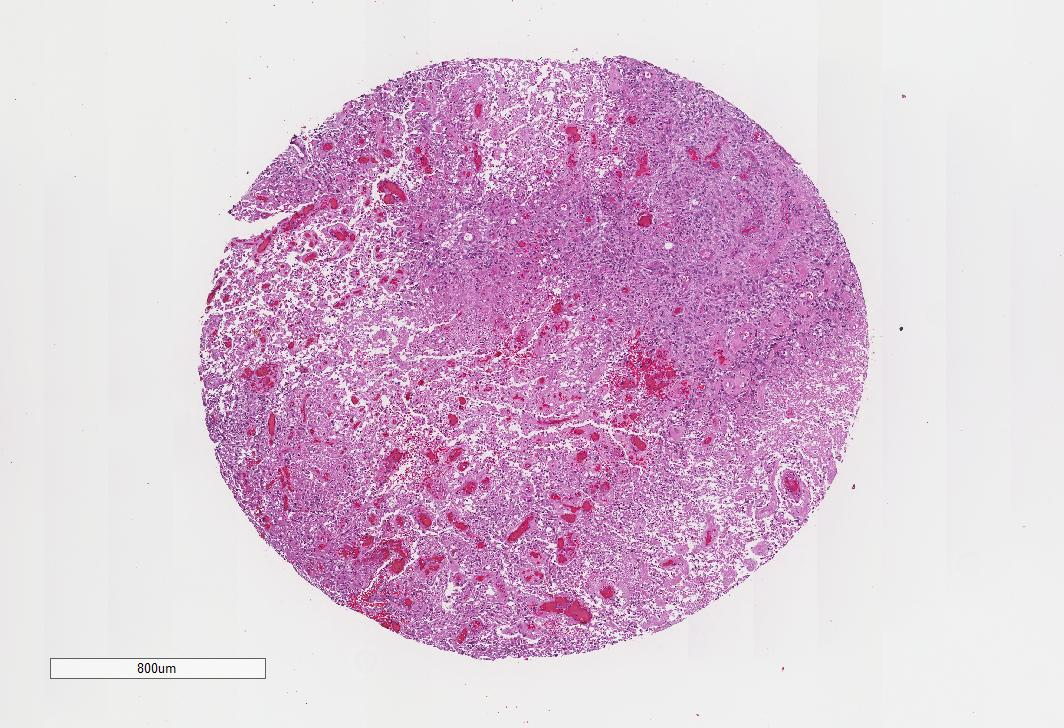

In [136]:
primary = list(data_dir.glob('primary/*'))
PIL.Image.open(str(primary[0]))

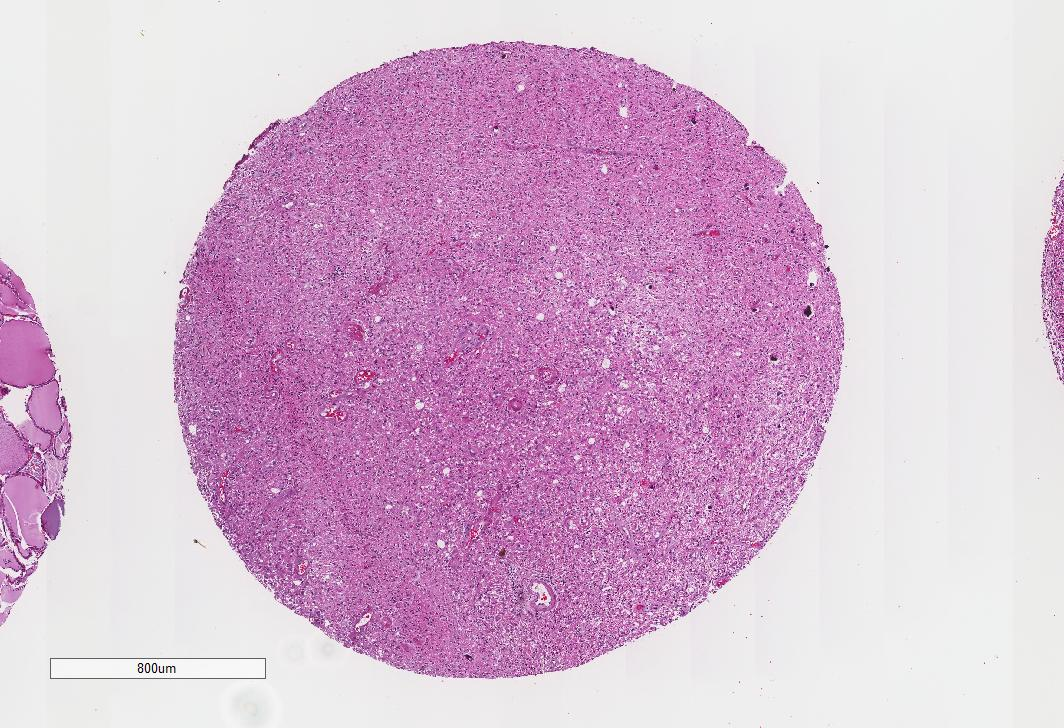

In [137]:

recurrent = list(data_dir.glob('recurrent/*'))
PIL.Image.open(str(recurrent[0]))

In [138]:
batch_size = 64
img_height = 224
img_width = 224

In [139]:
from PIL import Image
import glob

for name in data_dir.glob('*/*.tif'):
    im = Image.open(name)
    name = str(name).rstrip(".tif")
    im.save(name + '.jpg', 'JPEG')
print("Conversion from tif/tiff to jpg completed!")

Conversion from tif/tiff to jpg completed!


In [140]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 97 files belonging to 2 classes.
Using 78 files for training.


In [141]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 97 files belonging to 2 classes.
Using 19 files for validation.


In [142]:
class_names = train_ds.class_names
print(class_names)

['primary', 'recurrent']


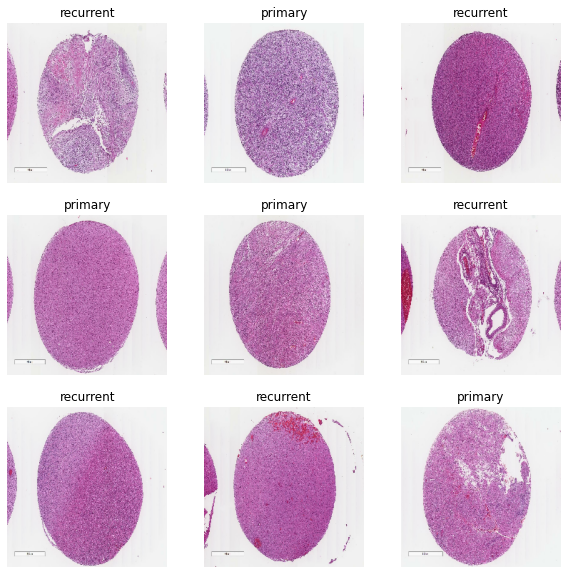

In [143]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [144]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 224, 224, 3)
(64,)


In [145]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [146]:
normalization_layer = layers.Rescaling(1./255)

In [147]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.027144609 1.0


In [148]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

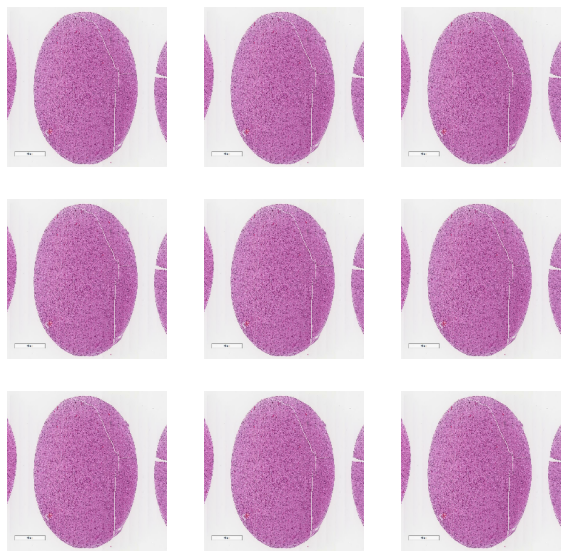

In [149]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [150]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='sigmoid'),
  layers.Dense(num_classes)
])

In [151]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [152]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_13 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 rescaling_13 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 56, 56, 32)       0         
 g2D)                                                

In [153]:
epochs=500
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/500
2/2 [==============================] - 2s 360ms/step - loss: 1.0756 - accuracy: 0.5897 - val_loss: 2.5655 - val_accuracy: 0.1579
Epoch 2/500
2/2 [==============================] - 0s 123ms/step - loss: 0.8209 - accuracy: 0.5897 - val_loss: 0.4400 - val_accuracy: 0.8421
Epoch 3/500
2/2 [==============================] - 0s 120ms/step - loss: 0.9030 - accuracy: 0.5897 - val_loss: 0.4356 - val_accuracy: 0.8421
Epoch 4/500
2/2 [==============================] - 0s 56ms/step - loss: 0.7686 - accuracy: 0.5897 - val_loss: 0.5108 - val_accuracy: 0.8421
Epoch 5/500
2/2 [==============================] - 0s 46ms/step - lo

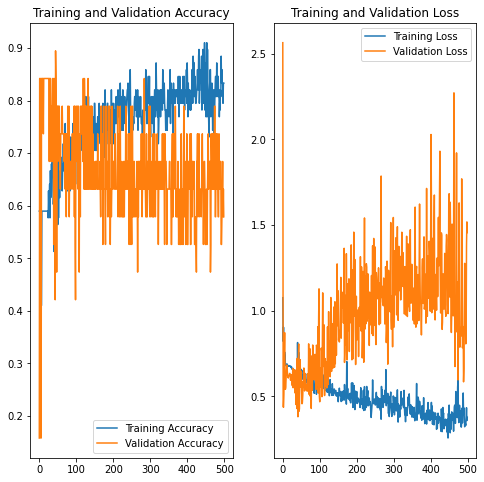

In [154]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [155]:
img = tf.keras.utils.load_img(
    'data/resized/23_N.jpg', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 99ms/step
This image most likely belongs to recurrent with a 99.41 percent confidence.
